<a href="https://colab.research.google.com/github/Gruensil/KI-Seminar/blob/main/tutorials/Open_Source_LLMs_Getting_Started.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Open Source LLMs: Getting Started

### Goal: Start generating text in the next 120 seconds

**By: Glenn Parham, [Defense Digital Service](https://dds.mil)**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/deptofdefense/LLMs-at-DoD/blob/main/tutorials/Open_Source_LLMs_Getting_Started.ipynb)

## Getting Started

In this colab notebook, we'll want to use a **T4** GPU (A100/V100 will also work).  You may switch to this by going to "Runtime" then "Change Runtime Type"

This accelerated GPU will ensure inference of LLMs will not take forever.

Let's verify you're using a T4.  Once you run this cell, you should get the following output (if you're not, skip this cell):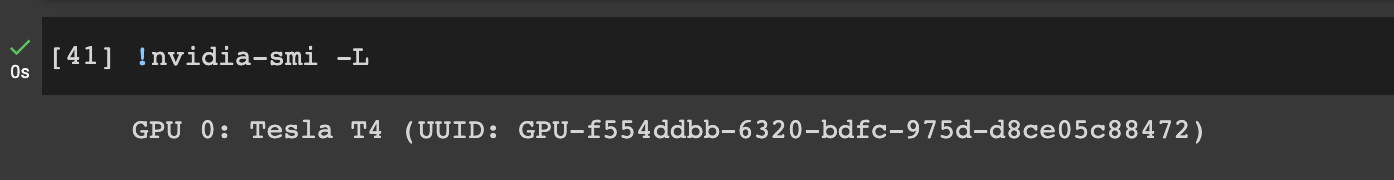

In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ea88581e-d522-243e-f683-d7fe7b003f92)


To get around annoying text-wrapping issues, run this cell.

In [3]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

## Installing Dependencies

You'll need to install the following requirements

Python Libraries
- HuggingFace
- Llama-cpp-python

In [8]:
## INSTALLING HUGGINGFACE
!pip install huggingface-hub -q

## INSTALLING llama-cpp-python
# GPU llama-cpp-python; Starting from version llama-cpp-python==0.1.79, it supports GGUF
!pip install llama-cpp-python --force-reinstall --upgrade --no-cache-dir


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 231.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 148.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 168.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.9/134.9 kB 192.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 175.1 MB/s eta 0:00:00
  Created wheel for llama-cpp-python: filename=llama_cpp_python-0.3.7-cp311-cp311-linux_x86_64.whl size=4601137 sha256=85106838512c782c0230cca54efb28c560ac0220222a88066bb426c5758a5c2b
  Stored in directory: /tmp/pip-ephem-wheel-cache-rgkp8pb2/wheels/eb/82/79/ac77fcd49324b75ae6aa18e63a87cf9da4371a57e2cdc8dc03
Successfully built llama-cpp-python
  Attempting uninstall: typing-extensions
    Found existing installat

Next, you'll need to download the model weights from HuggingFace.

Here's a list of models you can choose from: https://huggingface.co/models?pipeline_tag=text-generation&sort=trending&search=GGUF

Note: The model you select **must** be of type "GGUF"

GGUF is...
- binary file format for storing models for inference
- designed for fast loading and saving of models
- easy to use (with a few lines of code)
- mmap (memory mapping) compatibility: models can be loaded using mmap for fast loading and saving.

In [9]:
# @title Select Large Language Model
selected_llm = 'Mistral-7B-OpenOrca' # @param ["Mistral-7B", "Mistral-7B-OpenOrca", "Llama-2-13B-Chat"]

model_dic = {"Mistral-7B":{"HF_REPO_NAME":"TheBloke/Mistral-7B-Instruct-v0.1-GGUF","HF_MODEL_NAME":"mistral-7b-instruct-v0.1.Q4_K_M.gguf"},
           "Mistral-7B-OpenOrca":{"HF_REPO_NAME":"TheBloke/Mistral-7B-OpenOrca-GGUF","HF_MODEL_NAME":"mistral-7b-openorca.Q5_K_M.gguf"},
             "Llama-2-13B-Chat":{"HF_REPO_NAME":"TheBloke/Llama-2-13B-chat-GGUF","HF_MODEL_NAME":"llama-2-13b-chat.Q4_K_S.gguf"}
             }

In [10]:
import os

from huggingface_hub import hf_hub_download


HF_REPO_NAME = model_dic[selected_llm]['HF_REPO_NAME']
HF_MODEL_NAME = model_dic[selected_llm]['HF_MODEL_NAME']
LOCAL_DIR_NAME = "models"

os.makedirs(LOCAL_DIR_NAME, exist_ok=True)
model_path = hf_hub_download(
    repo_id=HF_REPO_NAME, filename=HF_MODEL_NAME, local_dir=LOCAL_DIR_NAME
)

Now, let's initialize the "Llama" framework.

So this is a bit messy.  Llama-cpp was named after Meta's open-source "*Llama*" LLMs.  The framework was built to make it easy to locally run & program with this LLM.  However, now, the framework as been abstracted and modified to work with ***any*** open-source text-generation LLM, as long as it is in the GGUF model file type.

In our case, we are using the Mistral open-source LLM and Llama-cpp as our framework.

In [11]:
from llama_cpp import Llama

llm = Llama(
    model_path=model_path,
    n_threads=2, # CPU cores
    n_batch=512, # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=30, # The max for this model is 30 in a T4, If you use llama 2 70B, you'll need to put fewer layers on the GPU
    n_ctx=4096, # Context window
)


llama_model_loader: loaded meta data with 20 key-value pairs and 291 tensors from models/mistral-7b-openorca.Q5_K_M.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = open-orca_mistral-7b-openorca
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv   7:                 llama.attenti

# The Fun Part

You're all ready to actually use this LLM!  Feel free to change the prompt variable to whatever you'd like.  Once you run the cell, it'll begin to stream the generated text.  The speed will depend on the GPU you selected (T4 vs. V100).

In [12]:
prompt = """
What is the US Department of Defense?
"""

In [13]:
response = llm(prompt,stream=True,stop=["\n\n"],temperature=0, max_tokens=200)
generated_text = ""
for output in response:
    result = output['choices'][0]['text']
    generated_text+=result
    print(result,end="")

The US Department of Defense (DoD) is the federal executive department responsible for coordinating and supervising all agencies and functions concerned with national security and the armed forces of the United States. The DoD was established on July 26, 1947, as a response to the need for a unified and effective defense establishment following World War II. The department is headed by the Secretary of Defense, who is a member of the president's Cabinet.

llama_perf_context_print:        load time =    5441.41 ms
llama_perf_context_print: prompt eval time =    5441.20 ms /    12 tokens (  453.43 ms per token,     2.21 tokens per second)
llama_perf_context_print:        eval time =   63385.81 ms /    98 runs   (  646.79 ms per token,     1.55 tokens per second)
llama_perf_context_print:       total time =   68943.54 ms /   110 tokens


In [15]:
def generiere_arztbrief(name, diagnose, behandlung):
    # Erstelle einen Prompt, der die Patientendaten strukturiert zusammenführt
    prompt = (
        f"Patient: {name}.\n"
        f"Diagnose: {diagnose}.\n"
        f"Behandlungsansatz: {behandlung}.\n\n"
        "Schreibe einen ausführlichen, professionellen Arztbrief, der die folgenden Informationen beinhaltet:"
        "\n- Patientendaten\n- Diagnose\n- Behandlungsplan und Empfehlungen\n- Weitere Anmerkungen\n\n"
        "Arztbrief:"
    )

    # Generiere den Arztbrief mit dem LLM
    response = llm(prompt,stream=True,stop=["\n\n"],temperature=0, max_tokens=200)
    generated_text = ""
    for output in response:
        result = output['choices'][0]['text']
        generated_text+=result
    return generated_text

In [17]:
print("Willkommen zum Arztbrief-Generator!")
print("Bitte gib die folgenden Daten ein:")

patientenname = input("Patientenname: ")
diagnose = input("Diagnose: ")
behandlung = input("Behandlungsansatz: ")

brief = generiere_arztbrief(patientenname, diagnose, behandlung)
print("\n----- Automatisch generierter Arztbrief -----\n")
print(brief)

Willkommen zum Arztbrief-Generator!
Bitte gib die folgenden Daten ein:
Patientenname: Max Mustermann
Diagnose: aktue Bronchitits
Behandlungsansatz: Empfehlung zur Schonung und symptomatischer Behandlung


Llama.generate: 1 prefix-match hit, remaining 110 prompt tokens to eval
llama_perf_context_print:        load time =    5441.41 ms
llama_perf_context_print: prompt eval time =  191429.66 ms /   219 tokens (  874.11 ms per token,     1.14 tokens per second)
llama_perf_context_print:        eval time =     607.28 ms /     1 runs   (  607.28 ms per token,     1.65 tokens per second)
llama_perf_context_print:       total time =   53736.15 ms /   220 tokens



----- Automatisch generierter Arztbrief -----


